# Diffusion models

## Introduction

Recently, diffusion models have emerged as the top contender for generative models. Let us explore diffusion models and get some intuition on how they work.

## Preparing the dataset

let us load `torch` as well as some data to approximate. For our purposes, we will use the MNIST dataset

In [4]:
import torch
import torchvision
import torchvision.datasets as datasets

import matplotlib.pyplot as plt

In [3]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)

100.0%


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100.0%


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100.0%

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




100.0%

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Let us visualize some examples from the dataset:

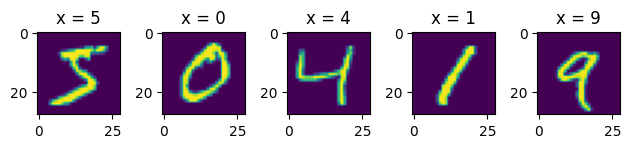

In [25]:
fig = plt.figure()
for i in range(0,5):
    ax = plt.subplot(1,5,i+1)
    data = mnist_trainset[i]
    ax.imshow(data[0])
    ax.set_title(f"x = {data[1]}")
fig.tight_layout()

## Preliminaries